<a href="https://colab.research.google.com/github/Ayesha-Imr/vision-mech-interp/blob/main/01_cnn_intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment 1: Building Intuition for CNNs

This notebook provides a clear mental model of how CNNs actually work.

**What we'll learn:**
- How images become tensors and then activations
- Convolutional filters as local pattern detectors
- How depth creates abstraction
- Why spatial locality matters

## Setup

We'll use a pretrained VGG16 - a simple, well-understood CNN architecture.

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

# Load pretrained VGG16
model = models.vgg16(pretrained=True)
model.eval()

# Standard ImageNet preprocessing
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Helper to load an image from URL
def load_image(url):
    # Add a User-Agent header to mimic a web browser
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(url, headers=headers)
    response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# Load a sample image (a cat)
img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg"
img = load_image(img_url)
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

print(f"Original image size: {img.size}")
print(f"Input tensor shape: {input_tensor.shape}  # [batch, channels, height, width]")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original image size: (1200, 1198)
Input tensor shape: torch.Size([1, 3, 224, 224])  # [batch, channels, height, width]


First Contact — Image → Tensors → Activations

**What happens when an image enters a CNN?**

1. The image becomes a tensor: `[batch, 3, 224, 224]` (3 RGB channels)
2. The first conv layer transforms it into `[batch, 64, 224, 224]` (64 feature maps)
3. Each feature map shows where a specific pattern was detected

The CNN doesn't "see" a cat. It sees 64 different filtered versions of the image, each highlighting different local patterns.

Input shape:  torch.Size([1, 3, 224, 224])   # 3 color channels
Output shape: torch.Size([1, 64, 224, 224])  # 64 feature maps


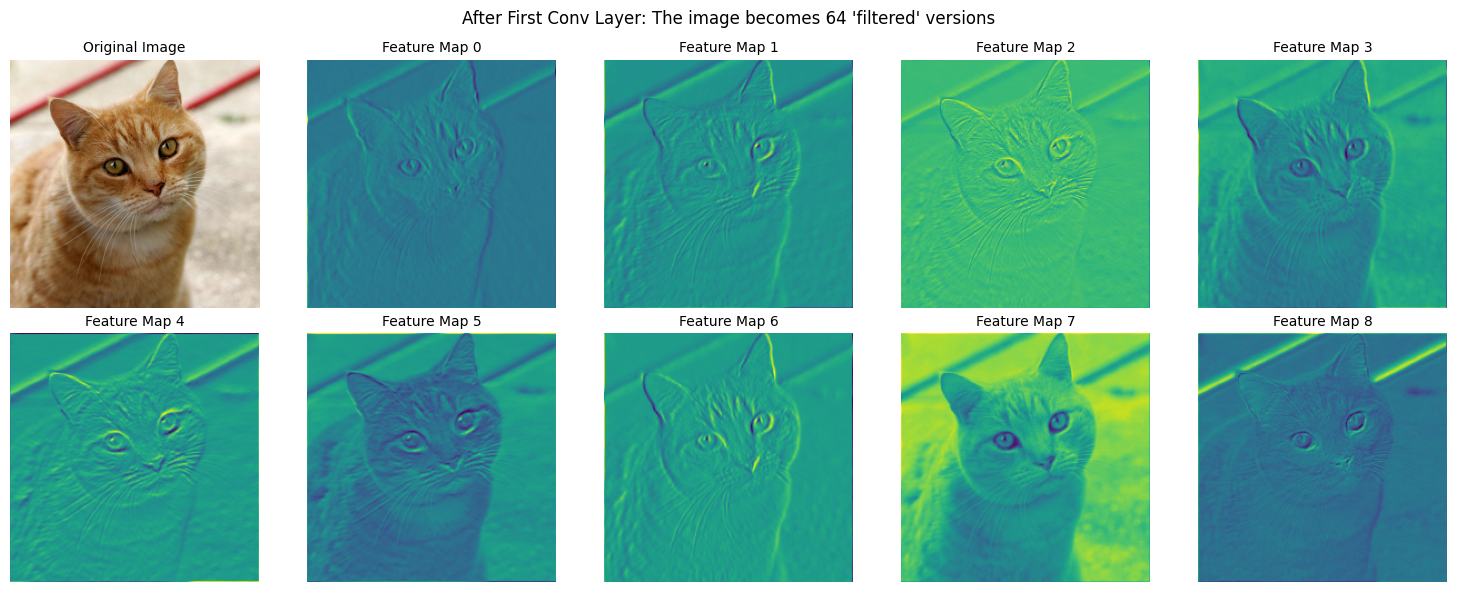


Each feature map highlights different edges/textures.
The CNN immediately distorts the image into pattern-specific responses.


In [5]:
# Extract activations from the first conv layer
first_conv = model.features[0]  # VGG16's first layer: Conv2d(3, 64, kernel_size=3)

with torch.no_grad():
    first_activations = first_conv(input_tensor)

print(f"Input shape:  {input_tensor.shape}   # 3 color channels")
print(f"Output shape: {first_activations.shape}  # 64 feature maps")

# Visualize: original image vs first 8 feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Original image
axes[0, 0].imshow(img)
axes[0, 0].set_title("Original Image", fontsize=10)
axes[0, 0].axis('off')

# First 9 feature maps
for i in range(9):
    row, col = (i + 1) // 5, (i + 1) % 5
    feature_map = first_activations[0, i].numpy()
    axes[row, col].imshow(feature_map, cmap='viridis')
    axes[row, col].set_title(f"Feature Map {i}", fontsize=10)
    axes[row, col].axis('off')

plt.suptitle("After First Conv Layer: The image becomes 64 'filtered' versions", fontsize=12)
plt.tight_layout()
plt.show()

print("\nEach feature map highlights different edges/textures.")
print("The CNN immediately distorts the image into pattern-specific responses.")

Convolution as Local Pattern Detection

**What are convolutional filters actually doing?**

Each filter is a small `3×3` (or `5×5`) pattern that slides across the image. When the filter encounters a matching pattern, it produces a high activation.

- **Same filter, different locations** → weight sharing (efficiency)
- **Different filters** → detect different patterns (edges, colors, textures)

Filter shape: torch.Size([64, 3, 3, 3])  # 64 filters, each 3x3x3 (RGB)


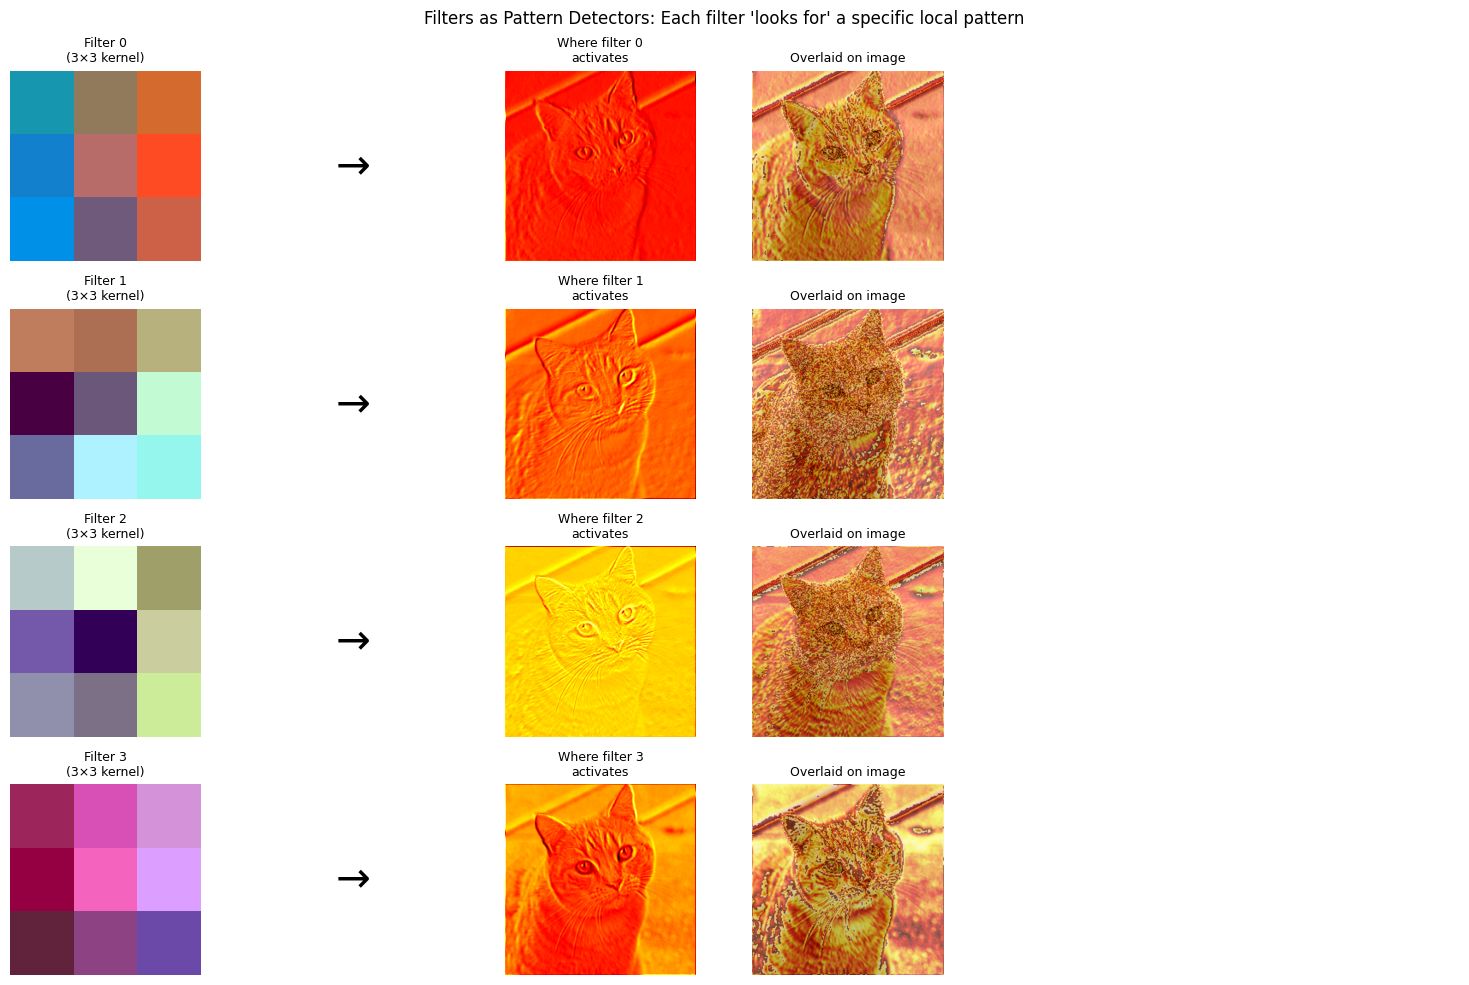


Some observations:
   • Each 3×3 filter detects a specific pattern (edge direction, color gradient, etc.)
   • The activation map shows WHERE that pattern appears in the image
   • Same filter activates in MULTIPLE locations → weight sharing


In [7]:
# Get the learned filters from the first conv layer
filters = first_conv.weight.data.clone()
print(f"Filter shape: {filters.shape}  # 64 filters, each 3x3x3 (RGB)")

# Visualize filters and their corresponding activations
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

for i in range(4):
    # Get the filter (normalize for visualization)
    filt = filters[i].permute(1, 2, 0).numpy()  # [3, 3, 3] -> [3, 3, 3]
    filt = (filt - filt.min()) / (filt.max() - filt.min())  # Normalize to [0,1]

    # Get corresponding activation map
    activation = first_activations[0, i].numpy()

    # Show filter
    axes[i, 0].imshow(filt)
    axes[i, 0].set_title(f"Filter {i}\n(3×3 kernel)", fontsize=9)
    axes[i, 0].axis('off')

    # Show what it detects (text annotation)
    axes[i, 1].text(0.5, 0.5, "→", fontsize=30, ha='center', va='center')
    axes[i, 1].axis('off')

    # Show activation map
    axes[i, 2].imshow(activation, cmap='hot')
    axes[i, 2].set_title(f"Where filter {i}\nactivates", fontsize=9)
    axes[i, 2].axis('off')

    # Highlight high activations on original
    axes[i, 3].imshow(img)
    # Overlay activation as alpha mask
    activation_resized = np.array(Image.fromarray((activation * 255).astype(np.uint8)).resize(img.size))
    axes[i, 3].imshow(activation_resized, cmap='hot', alpha=0.5)
    axes[i, 3].set_title("Overlaid on image", fontsize=9)
    axes[i, 3].axis('off')

    # Empty cells for spacing
    axes[i, 4].axis('off')
    axes[i, 5].axis('off')

plt.suptitle("Filters as Pattern Detectors: Each filter 'looks for' a specific local pattern", fontsize=12)
plt.tight_layout()
plt.show()

print("\nSome observations:")
print("   • Each 3×3 filter detects a specific pattern (edge direction, color gradient, etc.)")
print("   • The activation map shows WHERE that pattern appears in the image")
print("   • Same filter activates in MULTIPLE locations → weight sharing")

Depth = Abstraction

**The most important insight about CNNs:**

As we go deeper into the network:
- **Early layers** → edges, colors, simple textures
- **Middle layers** → patterns, motifs, object parts
- **Deep layers** → abstract, class-relevant, sparse activations

Abstraction emerges from stacking simple operations rather than a single layer.

Activation shapes at different depths:
  Early (layer 2):   torch.Size([1, 64, 224, 224])   # 64 channels, high resolution
  Middle (layer 16): torch.Size([1, 256, 28, 28])  # 256 channels, medium resolution
  Deep (layer 28):   torch.Size([1, 512, 14, 14])    # 512 channels, low resolution


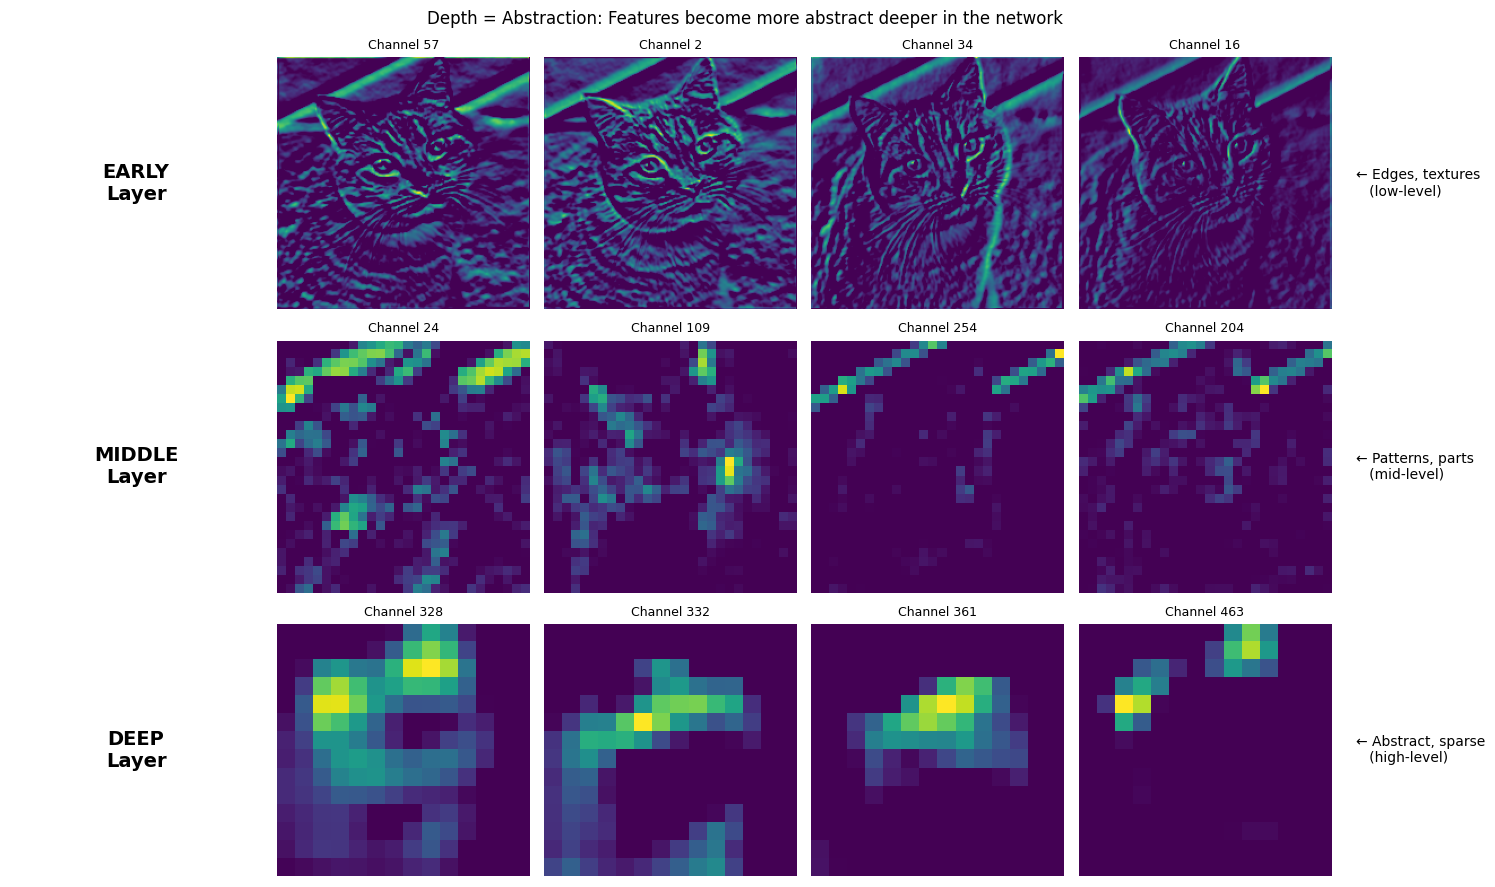


Observations:
   • EARLY: High resolution, many activations, edge-like patterns
   • MIDDLE: Lower resolution, more structured patterns
   • DEEP: Very low resolution, sparse activations, abstract features

   This is why WHERE you probe the network matters for interpretability.


In [10]:
# Hook to capture activations at different layers
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks at early, middle, and deep layers
# VGG16 structure: features[0-4]=block1, [5-9]=block2, [10-16]=block3, [17-23]=block4, [24-30]=block5
model.features[2].register_forward_hook(get_activation('early'))    # After first conv block
model.features[16].register_forward_hook(get_activation('middle'))  # Middle of network
model.features[28].register_forward_hook(get_activation('deep'))    # Near the end

# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

print("Activation shapes at different depths:")
print(f"  Early (layer 2):   {activations['early'].shape}   # 64 channels, high resolution")
print(f"  Middle (layer 16): {activations['middle'].shape}  # 256 channels, medium resolution")
print(f"  Deep (layer 28):   {activations['deep'].shape}    # 512 channels, low resolution")

# Visualize one channel from each depth
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for row, (name, act) in enumerate(activations.items()):
    # Show 4 random feature maps from this layer
    axes[row, 0].text(0.5, 0.5, f"{name.upper()}\nLayer", fontsize=14, ha='center', va='center', fontweight='bold')
    axes[row, 0].axis('off')

    # Pick 4 interesting channels (ones with high variance = more informative)
    variances = act[0].var(dim=[1, 2])
    top_channels = torch.argsort(variances, descending=True)[:4]

    for col, ch in enumerate(top_channels):
        feature_map = act[0, ch].numpy()
        axes[row, col + 1].imshow(feature_map, cmap='viridis')
        axes[row, col + 1].set_title(f"Channel {ch.item()}", fontsize=9)
        axes[row, col + 1].axis('off')

# Add annotations
axes[0, 4].text(1.1, 0.5, "← Edges, textures\n   (low-level)", fontsize=10, transform=axes[0, 4].transAxes, va='center')
axes[1, 4].text(1.1, 0.5, "← Patterns, parts\n   (mid-level)", fontsize=10, transform=axes[1, 4].transAxes, va='center')
axes[2, 4].text(1.1, 0.5, "← Abstract, sparse\n   (high-level)", fontsize=10, transform=axes[2, 4].transAxes, va='center')

plt.suptitle("Depth = Abstraction: Features become more abstract deeper in the network", fontsize=12)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("   • EARLY: High resolution, many activations, edge-like patterns")
print("   • MIDDLE: Lower resolution, more structured patterns")
print("   • DEEP: Very low resolution, sparse activations, abstract features")
print("\n   This is why WHERE you probe the network matters for interpretability.")

## Spatial Locality & Receptive Fields

**Why does spatial structure survive deep into the network?**

Each neuron in a deep layer only "sees" a portion of the original image - its **receptive field**. Deeper neurons have larger receptive fields but still maintain spatial correspondence.

CNNs trade spatial precision for semantic meaning gradually, not all at once.

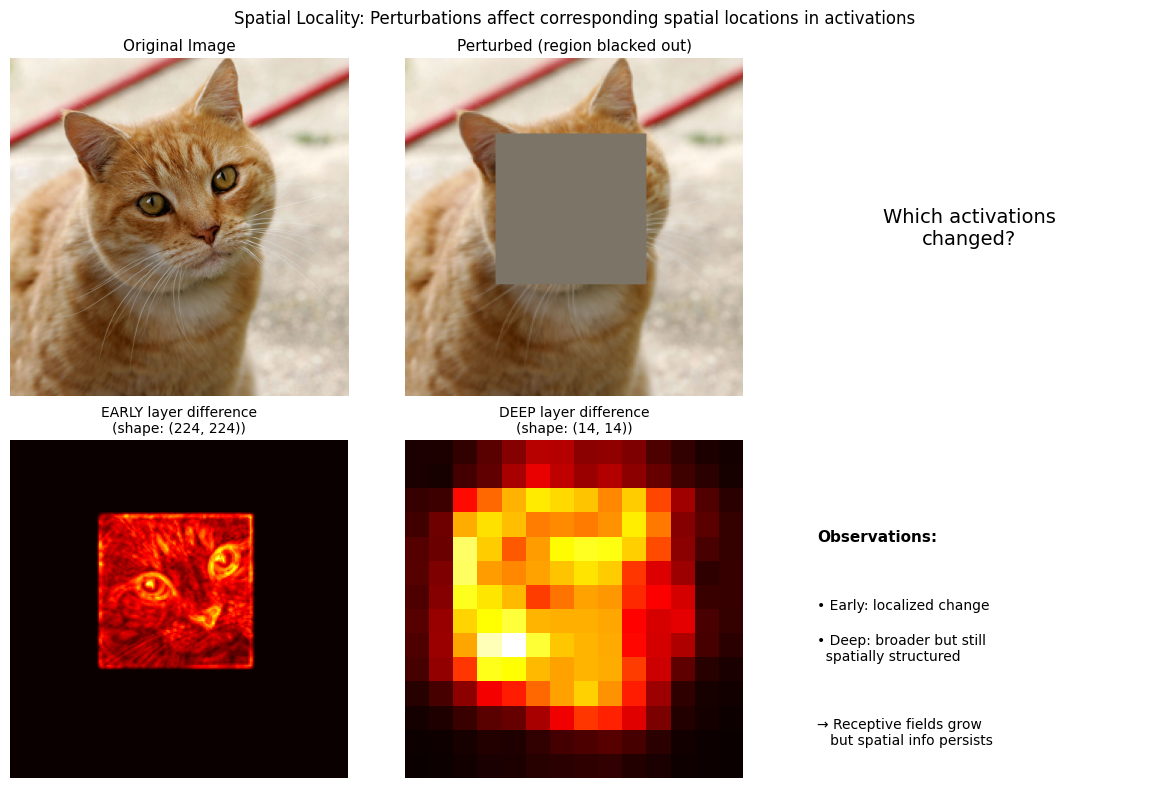

In [12]:
# Demonstrate: perturb a region and see which activations change
# This shows that deep layers still have spatial structure

# Create a perturbed version (black out the cat's face region)
perturbed_tensor = input_tensor.clone()
perturbed_tensor[:, :, 50:150, 60:160] = 0  # Black out a region

# Get activations for both
activations_original = {}
activations_perturbed = {}

def get_activation_dict(storage, name):
    def hook(model, input, output):
        storage[name] = output.detach()
    return hook

# Fresh model to avoid hook accumulation
model2 = models.vgg16(pretrained=True).eval()

# Register hooks
handles = []
handles.append(model2.features[2].register_forward_hook(get_activation_dict(activations_original, 'early')))
handles.append(model2.features[28].register_forward_hook(get_activation_dict(activations_original, 'deep')))

with torch.no_grad():
    _ = model2(input_tensor)

# Remove and re-register for perturbed
for h in handles:
    h.remove()

handles = []
handles.append(model2.features[2].register_forward_hook(get_activation_dict(activations_perturbed, 'early')))
handles.append(model2.features[28].register_forward_hook(get_activation_dict(activations_perturbed, 'deep')))

with torch.no_grad():
    _ = model2(perturbed_tensor)

# Compute difference maps
early_diff = (activations_original['early'] - activations_perturbed['early']).abs().mean(dim=1)[0]
deep_diff = (activations_original['deep'] - activations_perturbed['deep']).abs().mean(dim=1)[0]

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Row 1: Original vs Perturbed
axes[0, 0].imshow(img)
axes[0, 0].set_title("Original Image", fontsize=11)
axes[0, 0].axis('off')

# Show perturbed (denormalize for display)
perturbed_display = perturbed_tensor[0].permute(1, 2, 0).numpy()
perturbed_display = perturbed_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
perturbed_display = np.clip(perturbed_display, 0, 1)
axes[0, 1].imshow(perturbed_display)
axes[0, 1].set_title("Perturbed (region blacked out)", fontsize=11)
axes[0, 1].axis('off')

axes[0, 2].text(0.5, 0.5, "Which activations\nchanged?", fontsize=14, ha='center', va='center')
axes[0, 2].axis('off')

# Row 2: Difference maps
axes[1, 0].imshow(early_diff.numpy(), cmap='hot')
axes[1, 0].set_title(f"EARLY layer difference\n(shape: {tuple(early_diff.shape)})", fontsize=10)
axes[1, 0].axis('off')

axes[1, 1].imshow(deep_diff.numpy(), cmap='hot')
axes[1, 1].set_title(f"DEEP layer difference\n(shape: {tuple(deep_diff.shape)})", fontsize=10)
axes[1, 1].axis('off')

axes[1, 2].text(0.1, 0.7, "Observations:", fontsize=11, transform=axes[1, 2].transAxes, fontweight='bold')
axes[1, 2].text(0.1, 0.5, "• Early: localized change", fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.35, "• Deep: broader but still\n  spatially structured", fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.1, "→ Receptive fields grow\n   but spatial info persists", fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].axis('off')

plt.suptitle("Spatial Locality: Perturbations affect corresponding spatial locations in activations", fontsize=12)
plt.tight_layout()
plt.show()